## Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 


![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)



All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from astroML.classification import GMMBayes

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn import preprocessing

from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

from astroML.utils import completeness_contamination

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

import os
import datetime

import tensorflow as tf
from tensorflow import keras

### Data

In [3]:
data=h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [4]:
print(data.keys())

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>


In [5]:
mtot=data['mtot'][:]
q=data['q'][:]
z=data['z'][:]
iota=data['iota'][:]
psi=data['psi'][:]
chi1x=data['chi1x'][:]
chi1y=data['chi1y'][:]
chi1z=data['chi1z'][:]
chi2x=data['chi2x'][:]
chi2y=data['chi2y'][:]
chi2z=data['chi2z'][:]

snr=data['snr'][:]
det=data['det'][:]

In [6]:
X = np.array([mtot,q,z,iota,psi,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z]).T

print(X.shape)
print(snr, det)

(20000000, 11)
[0.82250949 1.09323729 1.30539835 ... 9.9752885  0.92040623 2.35090701] [0 0 0 ... 0 0 0]


Let's consider two subset of the data, the first generated directly from the dataset, while the other extracted from the rescaled dataset.

In [7]:
scaler = StandardScaler()
X_scale=scaler.fit_transform(X)

In [8]:
#create a subset
X_sub=X[::1000]
det_sub=det[::1000]
X_scale_sub=X_scale[::1000]

X_train, X_test, y_train, y_test = train_test_split(X, det, test_size=0.5, random_state=1)

X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, det_sub, test_size=0.5, random_state=1)

X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_scale_sub, det_sub, test_size=0.5, random_state=1)

Consider the different distributions of the features of the dataset, classifing them using the true labels.

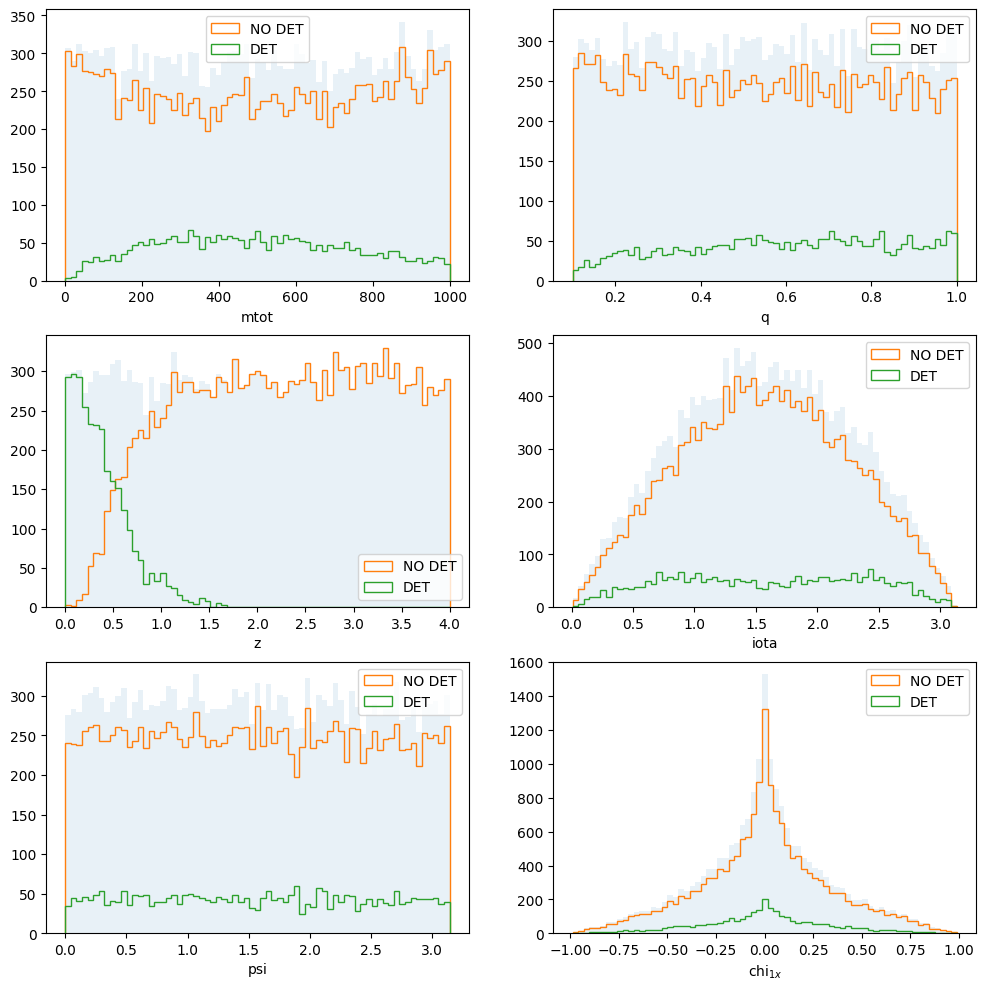

In [9]:
fig, ax = plt.subplots(3, 2, figsize = (12, 12))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1], ax[2,0], ax[2,1]]

lab=['mtot', 'q', 'z', 'iota', 'psi', 'chi$_{1x}$']

for a,i in zip(axs, range(len(X_sub[0,:]))):
    bins=np.linspace(min(X_sub[:,i]), max(X_sub[:,i]), 70)
    a.hist(X_sub[:,i], bins=bins, alpha=0.1)
    a.hist(X_sub[:,i][det_sub==0], bins=bins, histtype='step', lw=1, label='NO DET')
    a.hist(X_sub[:,i][det_sub==1], bins=bins, histtype='step', lw=1, label='DET')
    
    a.set_xlabel(lab[i])
    a.legend()

plt.show()

It seems that the most important features for the classification are the total mass, the mass ratio and the redshift of the source.

### Classification

Let's consider two classification alghoritms (`RandomForest` and `GradientBoosting`) and try to optimize the results that we will obtain.

In [38]:
def rms_error(x, y, clf):
    return np.sqrt(np.sum((clf.predict(x) - y) ** 2)
                   / len(y))

def errors_cv(X, y, clf):
    cverr = []
    trainerr = []
    
    for train_index, cv_index in kf.split(X):
        X_train, X_cv = X[train_index], X[cv_index]
        y_train, y_cv = y[train_index], y[cv_index]
        
        clf.fit(X_train, y_train)
        trainerr.append(rms_error(X_train, y_train, clf))
        cverr.append(rms_error(X_cv, y_cv, clf))
        #print(trainerr, cverr)
    
    return np.median(cverr), np.median(trainerr)

In [16]:
all_complet=[]
all_contam=[]
all_acc=[]

experiment=[]

*Random Forest*

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)

nt = np.linspace(15, 30, 15, dtype=int)
cverr_RF =[]
trainerr_RF = []

for n in nt:
    ranfor = RandomForestClassifier(n)
    cverr, trainerr = errors_cv(X_sub_train, y_sub_train, ranfor)
    cverr_RF.append(cverr)
    trainerr_RF.append(trainerr)
    
nt_best = nt[cverr_RF == min(cverr_RF)][0]
print('best number of trees:',nt_best)

best number of trees: 21


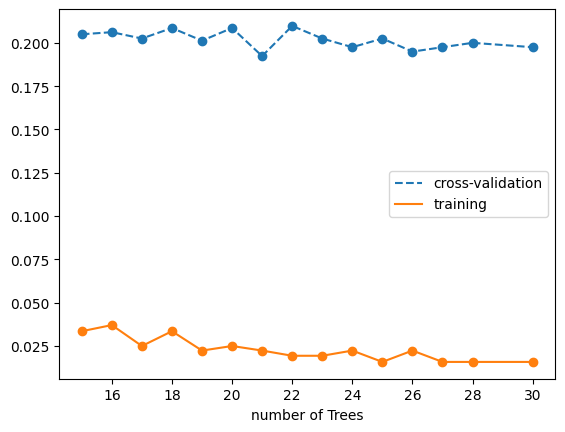

In [13]:
plt.scatter(nt, cverr_RF)
plt.scatter(nt, trainerr_RF)
plt.plot(nt, cverr_RF, '--', label='cross-validation')
plt.plot(nt, trainerr_RF, '-', label='training')
plt.legend()
plt.xlabel('number of Trees')
plt.show()

In [17]:
ranfor = RandomForestClassifier(nt_best, random_state=10)
ranfor.fit(X_sub_train,y_sub_train)

train_pred_sub = ranfor.predict(X_sub_train)
test_pred_sub = ranfor.predict(X_sub_test)

completeness_train_sub, contamination_train_sub = completeness_contamination(train_pred_sub, y_sub_train)

completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_test)

print("\ncompleteness train:", round(float(completeness_train_sub),3))
print("contamination train:", round(float(contamination_train_sub),3))

print("\ncompleteness test:", round(float(completeness_test_sub),3))
print("contamination test:", round(float(contamination_test_sub),3))

accuracy_sub = accuracy_score(y_sub_test, test_pred_sub)

print("\naccuracy:", round(float(accuracy_sub),3))

all_complet.append(completeness_test_sub)
all_contam.append(contamination_test_sub)
all_acc.append(accuracy_sub)

experiment.append("Random forest, 21 trees")


completeness train: 0.999
contamination train: 0.0

completeness test: 0.835
contamination test: 0.104

accuracy: 0.961


The classification presents a strong overfitting, completeness and contaimation of the train set are almost perfect, but when we generalize the result to the test set the performance decrease significately. Try to tune the max depth to decrease this effect.

In [18]:
rf=RandomForestClassifier(nt_best, random_state=10)

par = {'max_depth' : np.arange(1,25)}

grid = GridSearchCV(rf, param_grid=par, cv=5, n_jobs=-1)
grid.fit(X_sub_train, y_sub_train)
best_depth = grid.best_params_['max_depth']
print('maximum depth:', best_depth)

maximum depth: 17


In [19]:
ranfor = RandomForestClassifier(nt_best, max_depth=best_depth, random_state=10)
ranfor.fit(X_sub_train,y_sub_train)

train_pred_sub = ranfor.predict(X_sub_train)
test_pred_sub = ranfor.predict(X_sub_test)

completeness_train_sub, contamination_train_sub = completeness_contamination(train_pred_sub, y_sub_train)

completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_test)

print("\ncompleteness train:", round(float(completeness_train_sub),3))
print("contamination train:", round(float(contamination_train_sub),3))

print("\ncompleteness test:", round(float(completeness_test_sub),3))
print("contamination test:", round(float(contamination_test_sub),3))

accuracy_sub = accuracy_score(y_sub_test, test_pred_sub)

print("\naccuracy:", round(float(accuracy_sub),3))

all_complet.append(completeness_test_sub)
all_contam.append(contamination_test_sub)
all_acc.append(accuracy_sub)

experiment.append("Random forest, depth: 17")


completeness train: 0.996
contamination train: 0.001

completeness test: 0.831
contamination test: 0.108

accuracy: 0.959


Also in this case we are dominated by the overfitting, maybe we can try to change method.

*Gradient Boosting*

In [20]:
gb=GradientBoostingClassifier()

par = {'learning_rate' : np.linspace(0.01,0.1,4),
       'n_estimators' : np.linspace(50,250,5, dtype=int)}

grid = GridSearchCV(gb, param_grid=par, cv=5, n_jobs=-1)
grid.fit(X_sub_train, y_sub_train)
best_lr = grid.best_params_['learning_rate']
best_est = grid.best_params_['n_estimators']
print('best learning rate:', best_lr)
print('best number of estimators:', best_est)

best learning rate: 0.1
best number of estimators: 100


In [21]:
gradboost = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_est)
gradboost.fit(X_sub_train,y_sub_train)

train_pred_sub = gradboost.predict(X_sub_train)
test_pred_sub = gradboost.predict(X_sub_test)

completeness_train_sub, contamination_train_sub = completeness_contamination(train_pred_sub, y_sub_train)

completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_test)

print("\ncompleteness train:", round(float(completeness_train_sub),3))
print("contamination train:", round(float(contamination_train_sub),3))

print("\ncompleteness test:", round(float(completeness_test_sub),3))
print("contamination test:", round(float(contamination_test_sub),3))

accuracy_sub = accuracy_score(y_sub_test, test_pred_sub)

print("\naccuracy:", round(float(accuracy_sub),3))

all_complet.append(completeness_test_sub)
all_contam.append(contamination_test_sub)
all_acc.append(accuracy_sub)

experiment.append("Gradient Boosting")


completeness train: 0.896
contamination train: 0.065

completeness test: 0.852
contamination test: 0.102

accuracy: 0.963


The result seems quite good, without any strong sign of overfitting. We can try to improve it by considering the rescaled data.

In [22]:
#try with the scaled data

gradboost = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_est)
gradboost.fit(X_s_train,y_s_train)

train_pred_sub = gradboost.predict(X_s_train)
test_pred_sub = gradboost.predict(X_s_test)

completeness_train_sub, contamination_train_sub = completeness_contamination(train_pred_sub, y_s_train)

completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_s_test)

print("\ncompleteness train:", round(float(completeness_train_sub),3))
print("contamination train:", round(float(contamination_train_sub),3))

print("\ncompleteness test:", round(float(completeness_test_sub),3))
print("contamination test:", round(float(contamination_test_sub),3))

accuracy_sub = accuracy_score(y_s_test, test_pred_sub)

print("\naccuracy:", round(float(accuracy_sub),3))

all_complet.append(completeness_test_sub)
all_contam.append(contamination_test_sub)
all_acc.append(accuracy_sub)

experiment.append("Grad. Boosting, scaled data")


completeness train: 0.896
contamination train: 0.065

completeness test: 0.853
contamination test: 0.102

accuracy: 0.963


We obtained the same result. This is due to the fact that the Gradient Boosting Classifier do not depend on the dimensions of the various axis, like for example `K-Nearest Neighbors`. Despite that, we obtained quite a good result.

### Dimensionality reduction

Try to reduce the dimensionality of the data, this in principle could help the classification problem. Consider the two classifier we used before and, for each of them, apply a PCA algorithm.

*Random forest with PCA*

In [23]:
ndim = np.linspace(2, 11, 10, dtype=int)

best_nt=[]
complet=[]
contam=[]
acc=[]

for nd in ndim:
    pca = PCA(n_components = nd)
    X_reduced_sub = pca.fit_transform(X_sub)
    
    X_sub_r_train, X_sub_r_test, y_sub_r_train, y_sub_r_test = train_test_split(X_reduced_sub, det_sub,
                                                                                test_size=0.5, random_state=1)
    
    nt = np.linspace(5, 25, 25, dtype=int)
    cverr_RF =[]
    trainerr_RF = []

    for n in nt:
        ranfor = RandomForestClassifier(n)
        cverr, trainerr = errors_cv(X_sub_r_train, y_sub_r_train, ranfor)
        cverr_RF.append(cverr)
        trainerr_RF.append(trainerr)
    
    nt_best = nt[cverr_RF == min(cverr_RF)][0]
    
    ranfor = RandomForestClassifier(nt_best)
    ranfor.fit(X_sub_r_train,y_sub_r_train)

    train_pred_sub = ranfor.predict(X_sub_r_train)
    test_pred_sub = ranfor.predict(X_sub_r_test)
    
    completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_r_test)
    
    accuracy_test_sub = accuracy_score(y_sub_r_test, test_pred_sub)
    
    best_nt.append(nt_best)
    complet.append(round(float(completeness_test_sub),3))
    contam.append(round(float(contamination_test_sub),3))
    acc.append(round(float(accuracy_test_sub),3))

results = np.array([ndim, best_nt, complet, contam, acc]).T

col_names=["number of dimensions", "best number of trees", "completeness", "contamination", "accuracy"]

print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════════╤════════════════════════╤════════════════╤═════════════════╤════════════╕
│   number of dimensions │   best number of trees │   completeness │   contamination │   accuracy │
╞════════════════════════╪════════════════════════╪════════════════╪═════════════════╪════════════╡
│                      2 │                     16 │          0.752 │           0.158 │      0.941 │
├────────────────────────┼────────────────────────┼────────────────┼─────────────────┼────────────┤
│                      3 │                     19 │          0.778 │           0.157 │      0.945 │
├────────────────────────┼────────────────────────┼────────────────┼─────────────────┼────────────┤
│                      4 │                     21 │          0.821 │           0.143 │      0.953 │
├────────────────────────┼────────────────────────┼────────────────┼─────────────────┼────────────┤
│                      5 │                     20 │          0.814 │           0.136 │      0.953 │


In general performing a dimensionality reduction decreases the accuracy of the classifier.

*Gradient Boosting with PCA*

In [24]:
ndim = np.linspace(2, 11, 10, dtype=int)

complet=[]
contam=[]
acc=[]

for nd in ndim:
    pca = PCA(n_components = nd, random_state=10)
    X_reduced_sub = pca.fit_transform(X_sub)
    
    X_sub_r_train, X_sub_r_test, y_sub_r_train, y_sub_r_test = train_test_split(X_reduced_sub, det_sub, test_size=0.5, 
                                                                        random_state=1)
    
    gradboost = GradientBoostingClassifier(random_state=10)
    gradboost.fit(X_sub_r_train,y_sub_r_train)

    train_pred_sub = gradboost.predict(X_sub_r_train)
    test_pred_sub = gradboost.predict(X_sub_r_test)
    
    completeness_test_sub, contamination_test_sub = completeness_contamination(test_pred_sub, y_sub_r_test)
    
    accuracy_test_sub = accuracy_score(y_sub_r_test, test_pred_sub)
    
    complet.append(round(float(completeness_test_sub),3))
    contam.append(round(float(contamination_test_sub),3))
    acc.append(round(float(accuracy_test_sub),3))
    
results = np.array([ndim, complet, contam, acc]).T

col_names=["number of dimensions", "completeness", "contamination", "accuracy"]

print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════════╤════════════════╤═════════════════╤════════════╕
│   number of dimensions │   completeness │   contamination │   accuracy │
╞════════════════════════╪════════════════╪═════════════════╪════════════╡
│                      2 │          0.793 │           0.146 │      0.948 │
├────────────────────────┼────────────────┼─────────────────┼────────────┤
│                      3 │          0.788 │           0.145 │      0.948 │
├────────────────────────┼────────────────┼─────────────────┼────────────┤
│                      4 │          0.828 │           0.124 │      0.957 │
├────────────────────────┼────────────────┼─────────────────┼────────────┤
│                      5 │          0.822 │           0.123 │      0.956 │
├────────────────────────┼────────────────┼─────────────────┼────────────┤
│                      6 │          0.829 │           0.127 │      0.956 │
├────────────────────────┼────────────────┼─────────────────┼────────────┤
│                      7 

It seems that the accuracy increases significantly until we reach the $4^{th}$ dimensions. Let's consider this case and optimize the classifier for this value of the PCA. But first let's consider the **scree plot** to observe how much of the variance is explained as a function of the each eigenvector.

In [10]:
pca = PCA(n_components=11, random_state=10)
pca.fit(X_sub)
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Expained fractional variance of data encapsulated in the eigenvalues: [9.99960276e-01 1.58011341e-05 9.69398986e-06 5.56963125e-06
 1.34404476e-06 1.33434779e-06 1.31450368e-06 1.29927335e-06
 1.29669946e-06 1.27308740e-06 7.97628215e-07]


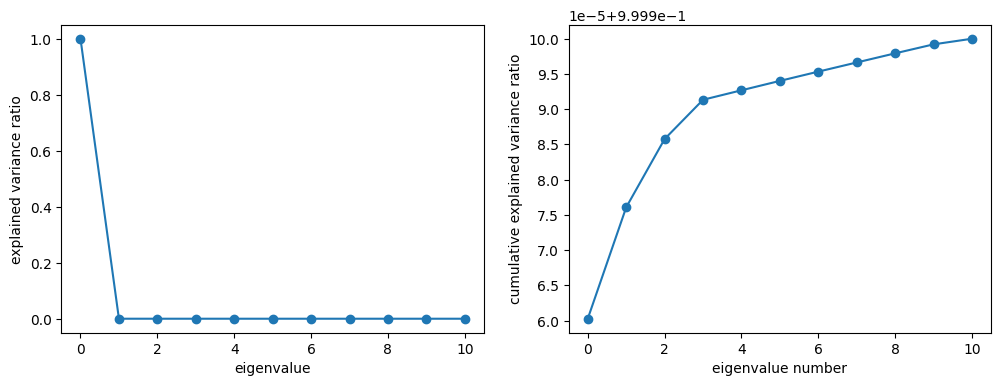

In [14]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)

ax.plot(np.arange(11), evals)
ax.scatter(np.arange(11), evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(np.arange(11), evals.cumsum())
ax.scatter(np.arange(11), evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

We can observe that the curve becomes less steep once you reach the $3^{rd}-4^{th}$ component. Well we can also notice that in principle the first component explain the $99.9\%$ of the variace!

In [25]:
pca = PCA(n_components = 4, random_state=10)
X_best = pca.fit_transform(X_sub)
    
X_best_train, X_best_test, y_best_train, y_best_test = train_test_split(X_best, det_sub, test_size=0.5, 
                                                                        random_state=1)

gb=GradientBoostingClassifier()

par = {'learning_rate' : np.linspace(0.01,0.1,4),
       'n_estimators' : np.linspace(50,250,5, dtype=int)}

grid = GridSearchCV(gb, param_grid=par, cv=5, n_jobs=-1)
grid.fit(X_best_train, y_best_train)
best_lr = grid.best_params_['learning_rate']
best_est = grid.best_params_['n_estimators']
print('best learning rate:', best_lr)
print('best number of estimators:', best_est)

best learning rate: 0.1
best number of estimators: 150


In [26]:
gradboost = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_est, random_state=10)
gradboost.fit(X_best_train,y_best_train)

train_pred = gradboost.predict(X_best_train)
test_pred = gradboost.predict(X_best_test)

completeness_train, contamination_train = completeness_contamination(train_pred, y_best_train)

completeness_test, contamination_test = completeness_contamination(test_pred, y_best_test)

print("\ncompleteness train:", round(float(completeness_train),3))
print("contamination train:", round(float(contamination_train),3))

print("\ncompleteness test:", round(float(completeness_test),3))
print("contamination test:", round(float(contamination_test),3))

accuracy = accuracy_score(y_best_test, test_pred)

print("\naccuracy:", round(float(accuracy),3))

all_complet.append(completeness_test)
all_contam.append(contamination_test)
all_acc.append(accuracy)

experiment.append("Grad. Boosting, PCA 4 components")


completeness train: 0.866
contamination train: 0.093

completeness test: 0.833
contamination test: 0.126

accuracy: 0.957


If we consider that we reduced the dimensionality of the problem from $11$ to $4$ this is quite a good result. Consider the total mass and the redshift and compare the true and predicted labels.

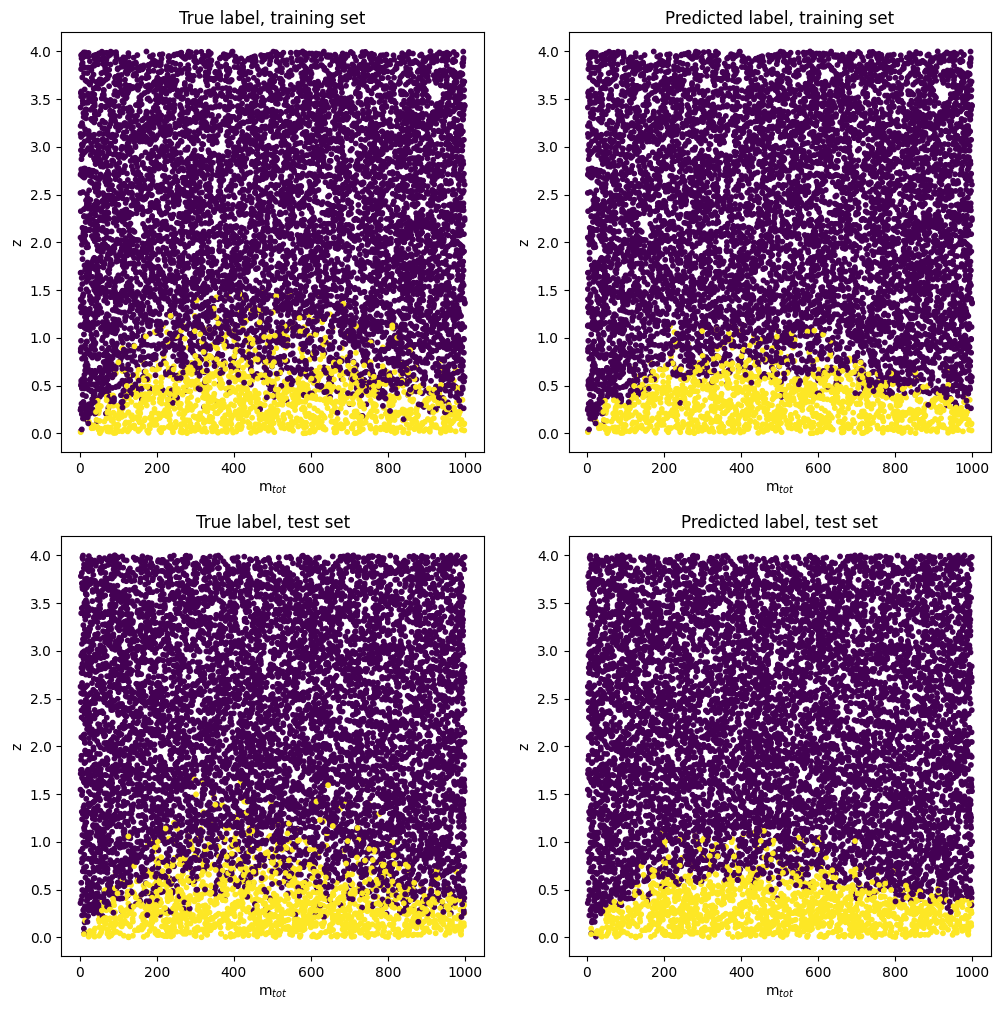

In [27]:
s=10

fig = plt.figure(figsize=(12,12))

ax=fig.add_subplot(221)
plt.scatter(X_sub_train[:,0], X_sub_train[:,2], c=y_sub_train, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('True label, training set')

ax=fig.add_subplot(222)
plt.scatter(X_sub_train[:,0], X_sub_train[:,2], c=train_pred, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('Predicted label, training set')

ax=fig.add_subplot(223)
plt.scatter(X_sub_test[:,0], X_sub_test[:,2], c=y_sub_test, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('True label, test set')

ax=fig.add_subplot(224)
plt.scatter(X_sub_test[:,0], X_sub_test[:,2], c=test_pred, s=s)
plt.xlabel('m$_{tot}$')
plt.ylabel('z')
plt.title('Predicted label, test set')

plt.show()

Seems that, in the test set, the classification struggles to distinguish between the two classes where the two overlap.

### Subset of data

Consider now only a small subset of the data, in particular let's consider only:
* Total mass
* Mass ratio
* Redshift
* Iota

In [28]:
X_1 = np.array([mtot,q,z,iota]).T
X_1=X_1[::1000]

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, det_sub, test_size=0.5, random_state=1)

gb=GradientBoostingClassifier()

par = {'learning_rate' : np.linspace(0.01,0.1,4),
       'n_estimators' : np.linspace(50,250,5, dtype=int)}

grid = GridSearchCV(gb, param_grid=par, cv=5, n_jobs=-1)
grid.fit(X_1_train, y_1_train)
best_lr = grid.best_params_['learning_rate']
best_est = grid.best_params_['n_estimators']
print('best learning rate:', best_lr)
print('best number of estimators:', best_est)

best learning rate: 0.1
best number of estimators: 200


In [29]:
gradboost = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_est, random_state=10)
gradboost.fit(X_1_train,y_1_train)

train_pred_1 = gradboost.predict(X_1_train)
test_pred_1 = gradboost.predict(X_1_test)

completeness_train, contamination_train = completeness_contamination(train_pred_1, y_1_train)

completeness_test, contamination_test = completeness_contamination(test_pred_1, y_1_test)

print("\ncompleteness train:", round(float(completeness_train),3))
print("contamination train:", round(float(contamination_train),3))

print("\ncompleteness test:", round(float(completeness_test),3))
print("contamination test:", round(float(contamination_test),3))

accuracy_1 = accuracy_score(y_1_test, test_pred_1)

print("\naccuracy:", round(float(accuracy_1),3))

all_complet.append(completeness_test)
all_contam.append(contamination_test)
all_acc.append(accuracy_1)

experiment.append("Grad. Boosting, subset") 


completeness train: 0.897
contamination train: 0.064

completeness test: 0.854
contamination test: 0.108

accuracy: 0.962


Even if we considered a small subset of the data (only $4$ features) the result is quite good. It's better than what we found conisdering the PCA with $4$ components.

### Comparison

Compare now all the results that we obtained.

In [30]:
#comparison

from tabulate import tabulate

results = np.array([experiment, all_complet, all_contam, all_acc]).T

col_names=["Method", "completeness", "contamination", "accuracy"]

print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))

╒══════════════════════════════════╤════════════════╤═════════════════╤════════════╕
│ Method                           │   completeness │   contamination │   accuracy │
╞══════════════════════════════════╪════════════════╪═════════════════╪════════════╡
│ Random forest, 21 trees          │       0.835325 │        0.103989 │     0.9606 │
├──────────────────────────────────┼────────────────┼─────────────────┼────────────┤
│ Random forest, depth: 17         │       0.830677 │        0.107703 │     0.9594 │
├──────────────────────────────────┼────────────────┼─────────────────┼────────────┤
│ Gradient Boosting                │       0.851926 │        0.102169 │     0.9631 │
├──────────────────────────────────┼────────────────┼─────────────────┼────────────┤
│ Grad. Boosting, scaled data      │       0.85259  │        0.102098 │     0.9632 │
├──────────────────────────────────┼────────────────┼─────────────────┼────────────┤
│ Grad. Boosting, PCA 4 components │       0.832669 │        0.12

In general all the classifications provide results which are quite similar to each other. The problem with *Random Forest* is the overfitting, which is present also if we increase the maximum depth. *Gradient Boosting* instead provides great results. It's interesting the fact that, if we consider only the total mass, mass ratio, redshift and iota, we get only slightly worse results than in the case where we considered the entire dataset.

At the end we obtained an accuracy of $\simeq96.3\%$.

### Regression on SNR

Let's try instead of a classification on the detectability, a regression on the Signal to Noise ratio. Consider as a regressor `KNeighborsRegressor`, this beacuse we expect events with similar characteristics have similar values of the SNR.

In [6]:
X_regr= np.array([mtot,q,z,iota]).T

print(X_regr.shape)

(20000000, 4)


In [7]:
scaler = StandardScaler()
X_regr=scaler.fit_transform(X_regr)

In [8]:
#create a subset
X_regr_sub=X_regr[::1000]
snr_sub=snr[::1000]
det_sub=det[::1000]

X_regr_train, X_regr_test, y_regr_train, y_regr_test, det_train, det_test = train_test_split(X_regr_sub,snr_sub, 
                                                                                             det_sub,test_size=0.5,
                                                                                             random_state=1)

In [14]:
KN_regr=KNeighborsRegressor()

KN_regr.fit(X_regr_train,y_regr_train)

train_pred_regr = KN_regr.predict(X_regr_train)
test_pred_regr = KN_regr.predict(X_regr_test)

Let's now assign the label $0$ if the SNR<$12$, $1$ otherwise.

In [15]:
det_regr_train=np.array(train_pred_regr>12, dtype=int)

print(det_regr_train)
print(train_pred_regr)

det_regr_test=np.array(test_pred_regr>12, dtype=int)

print(det_regr_test)
print(test_pred_regr)

[0 1 1 ... 0 0 0]
[ 0.81993354 39.85401001 44.42196854 ...  7.51174701  3.40510007
  3.32310293]
[0 0 0 ... 0 0 0]
[6.27080026 3.37106939 1.71029852 ... 1.70399945 3.48199017 0.97089236]


In [16]:
completeness_train, contamination_train = completeness_contamination(det_regr_train, det_train)

completeness_test, contamination_test = completeness_contamination(det_regr_test, det_test)

print("\ncompleteness train:", round(float(completeness_train),3))
print("contamination train:", round(float(contamination_train),3))

print("\ncompleteness test:", round(float(completeness_test),3))
print("contamination test:", round(float(contamination_test),3))

accuracy_1 = accuracy_score(det_test, det_regr_test)

print("\naccuracy:", round(float(accuracy_1),3))


completeness train: 0.902
contamination train: 0.16

completeness test: 0.887
contamination test: 0.19

accuracy: 0.952


Well this is a very good result, if we consider that we applied it only to a small subset of the data (only $4$ features). We obtain the highest completeness, but on the other hand also the contamination increased. At the end the accuracy is comparable with the classification result.

Try with `RandomForestRegressor`

In [17]:
RF_regr=RandomForestRegressor()

RF_regr.fit(X_regr_train,y_regr_train)

train_pred_regr = RF_regr.predict(X_regr_train)
test_pred_regr = RF_regr.predict(X_regr_test)

det_regr_train=np.array(train_pred_regr>12, dtype=int)

det_regr_test=np.array(test_pred_regr>12, dtype=int)

completeness_train, contamination_train = completeness_contamination(det_regr_train, det_train)

completeness_test, contamination_test = completeness_contamination(det_regr_test, det_test)

print("\ncompleteness train:", round(float(completeness_train),3))
print("contamination train:", round(float(contamination_train),3))

print("\ncompleteness test:", round(float(completeness_test),3))
print("contamination test:", round(float(contamination_test),3))

accuracy_1 = accuracy_score(det_test, det_regr_test)

print("\naccuracy:", round(float(accuracy_1),3))


completeness train: 0.963
contamination train: 0.063

completeness test: 0.895
contamination test: 0.144

accuracy: 0.962


We got some interesting results, maybe it would be interesting to investigate this topic further.